# Roughness Penalty Function

This is a demo notebook to illustate a roughness penalty for regression networks which penalizes non-smoothness of the predicted output among itself. Ideally the penalty is combined with other loss functions similiar to a regularization penalties.

In [1]:
# Import standard libraries
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
import time

t1 = time.time()

# Import custom loss function
sys.path.append(os.path.abspath('../functions'))
from custom_loss_functions import roughness_penalty

t2 = time.time()

print("Time to import smoothness loss function is %f [s]" % (t2 - t1))

Time to import smoothness loss function is 1.643473 [s]


Making a temporary input data of 1 sample.

In [2]:
input_width = 20
X = 1. + np.sin(
    2.*np.pi/(input_width - 1)*np.arange(input_width)
).reshape((1, input_width))  +  0.75*(np.random.rand(1, input_width) - 0.5)  # if you want to test random inputs
Y = X  # for training an identity function.

Creating a simple sequential neural network with the smoothness_penalty as the loss function.

In [3]:
# Model constants
network_width = input_width
n_layers = 10
degree = 5

# Alter loss function as keras models expect f(yactual, ypred)
def metric_function(yactual, ypred, degree=degree):
    return roughness_penalty(ypred, degree)

# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(network_width, activation=tf.nn.leaky_relu, input_shape=(input_width,)))
for _ in range(1, n_layers):
    model.add(tf.keras.layers.Dense(network_width, activation=tf.nn.leaky_relu))

# Compile and show model characteristics
model.compile(
    optimizer='adam',
    # loss=loss_function,
    loss=tf.keras.losses.MSE,
    metrics=[metric_function],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                4

Use the simple input data to see output prediction as well as the loss value.

In [4]:
Ypred = model.predict(X)
loss_value, metric_value = model.evaluate(X, Y)

1/1 [==============================] - 0s 495ms/sample - loss: 1.4433 - metric_function: 0.0232


Find the minimim sum of squared error polynomial for the output.

In [5]:
# SSE for polynomial of best fit of output
dtype = np.float32  # default 32-bit float for tensorflow on my machine
base, power = np.meshgrid(np.arange(input_width, dtype=dtype), np.arange(degree + 1, dtype=dtype), indexing='ij')
Xreg = base ** power
Xregt = Xreg.transpose()
XtXinv = np.linalg.inv(np.matmul(Xregt, Xreg))
theta = np.matmul(XtXinv, np.matmul(Xregt, Ypred.transpose().astype(dtype))).astype(dtype)

# Creating the polynomial function
def p(t):
    """LSE polynomial evaluation a t"""
    coeff = theta[:,0]
    power = np.arange(degree + 1)
    return np.sum(coeff * (t ** power))

# Vectorizing that polynomial funciton
pvec = np.vectorize(p)

Show the predicted values in a scatter plot and display the polynomial of best fit.

<IPython.core.display.Javascript object>


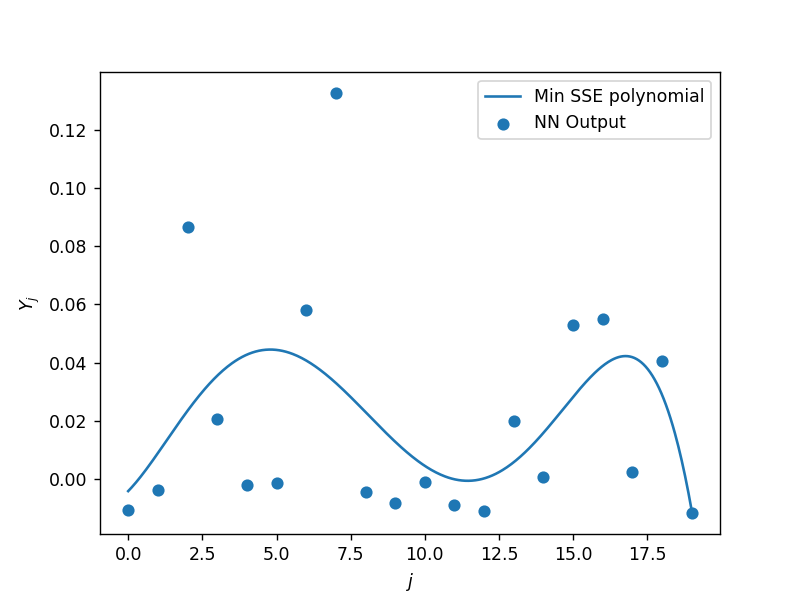

In [6]:
fig, ax = plt.subplots(1,1)

# Inputs
xplotting = np.arange(input_width)
xcont = np.linspace(0, input_width - 1, 501)

# plotting
ax.scatter(xplotting, Ypred[0,:], label='NN Output')
ax.plot(xcont, pvec(xcont), label='Min SSE polynomial')

# Axis labeling
ax.set_xlabel('$j$')
ax.set_ylabel('$Y_j$')

plt.legend()
plt.show()

Checking the tensorflow reported value for the penalty

In [7]:
sse_poly = np.sum((Ypred[0,:] - pvec(np.arange(input_width))) ** 2)
print("Tensorflow Smoothness Penalty: %f" % metric_value)
print("Calculated Smoothness Penalty: %f" % sse_poly)

Tensorflow Smoothness Penalty: 0.023169
Calculated Smoothness Penalty: 0.023162


Running traning to show the evolution of both loss function and roughness penalty.

<IPython.core.display.Javascript object>


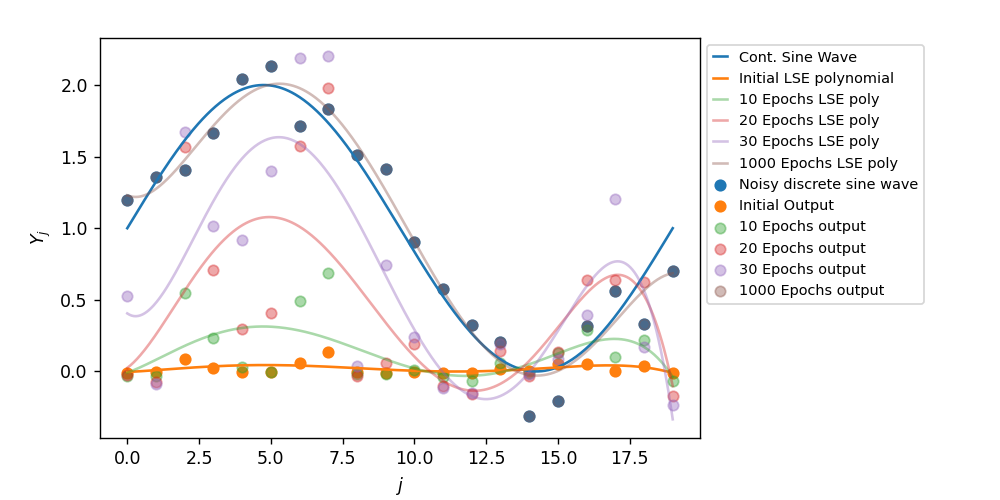

In [8]:
total_epochs = 1000
epochs_to_go = total_epochs
epochs_per_group = 10
n_epochs = 3

loss_h = np.array([loss_value])
metric_h = np.array([metric_value])

# fig, ax = plt.subplots(1, 1)
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0.1, 0.125, 0.6, 0.8])

ax.scatter(xplotting, Y[0, :], label='Noisy discrete sine wave')
ax.plot(xcont, 1 + np.sin(2.*np.pi/(input_width - 1)*xcont), label='Cont. Sine Wave')
ax.scatter(xplotting, model.predict(X)[0, :], label='Initial Output')
ax.plot(xcont, pvec(xcont), label='Initial LSE polynomial')

# Group Training
for i in range(n_epochs):
    epoch_label = "%i Epochs" % ((i+1)*epochs_per_group)
    
    # Train for a specific epoch
    hist = model.fit(x=X, y=Y, epochs=epochs_per_group, verbose=0)
    epochs_to_go -= epochs_per_group
    
    # Append the loss and metric values
    loss_h = np.concatenate((loss_h, hist.history['loss']))
    metric_h = np.concatenate((metric_h, hist.history['metric_function']))
    
    # Plot the outputs
    ypred = model.predict(X)
    ax.scatter(
        xplotting, ypred[0, :],
        label=(epoch_label + " output"),
        alpha=0.4
    )
    
    # Find the LSE polynomial
    theta = np.matmul(XtXinv, np.matmul(Xregt, ypred.transpose().astype(dtype))).astype(dtype)
    
    def p(t):
        """LSE polynomial evaluation a t"""
        coeff = theta[:,0]
        power = np.arange(degree + 1)
        return np.sum(coeff * (t ** power))

    pvec = np.vectorize(p)  # Vectorizing that polynomial function
    
    # Plot the LSE polynomial
    ax.plot(
        xcont, pvec(xcont),
        label=(epoch_label + " LSE poly"),
        alpha=0.4
    )

# Last training
epoch_label = "%i Epochs" % total_epochs

# Train for a specific epoch
hist = model.fit(x=X, y=Y, epochs=epochs_to_go, verbose=0)

# Append the loss and metric values
loss_h = np.concatenate((loss_h, hist.history['loss']))
metric_h = np.concatenate((metric_h, hist.history['metric_function']))

# Plot the outputs
ypred = model.predict(X)
ax.scatter(
    xplotting, ypred[0, :],
    label=(epoch_label + " output"),
    alpha=0.4
)

# Find the LSE polynomial
theta = np.matmul(XtXinv, np.matmul(Xregt, ypred.transpose().astype(dtype))).astype(dtype)

def p(t):
    """LSE polynomial evaluation a t"""
    coeff = theta[:,0]
    power = np.arange(degree + 1)
    return np.sum(coeff * (t ** power))

pvec = np.vectorize(p)  # Vectorizing that polynomial function

# Plot the LSE polynomial
ax.plot(
    xcont, pvec(xcont),
    label=(epoch_label + " LSE poly"),
    alpha=0.4
)
# Some figure setup
ax.set_xlabel('$j$')
ax.set_ylabel('$Y_j$')

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small', handlelength=1)

plt.show()

<IPython.core.display.Javascript object>


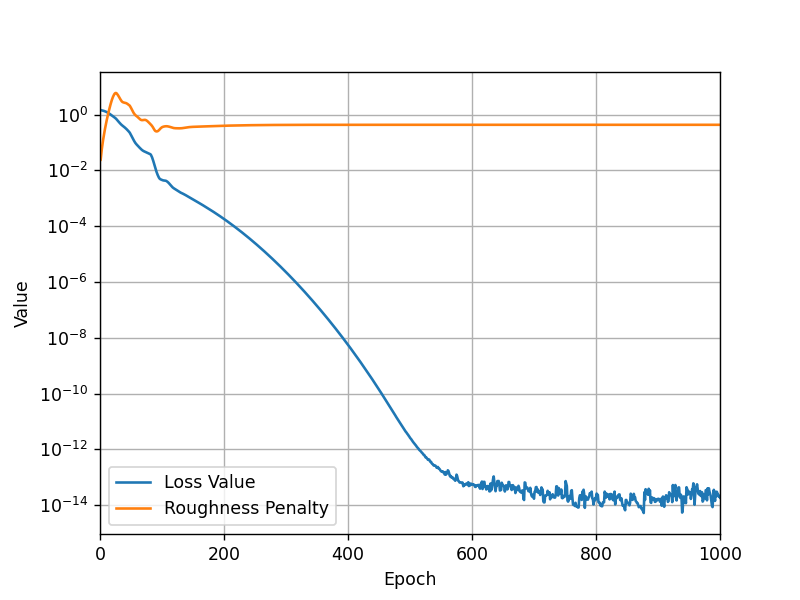

In [12]:
fig, ax = plt.subplots(1,1)

epoch_vec = np.arange(len(metric_h))
ax.plot(epoch_vec, loss_h, label="Loss Value")
ax.plot(epoch_vec, metric_h, label="Roughness Penalty")

ax.set_xlabel("Epoch")
ax.set_xlim(left=0,  right=total_epochs)
ax.set_ylabel("Value")
ax.set_yscale('log')
ax.grid(True, which='both')

plt.legend()
plt.show()

In [15]:
loss_and_metric = loss_h + metric_h

min_val = np.min(loss_and_metric)
min_val_e = np.argmin(loss_and_metric)

print("Minimum combined value: %f" % min_val)
print("Optimum epoch: %i" % min_val_e)

Minimum combined value: 0.256732
Optimum epoch: 92
